# CPI prediction

In [2]:
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

## Data gathering

Data was downloaded from the source noted in the text body of the document, manully copied into a file "joined.csv".

### OG: output gap

In [162]:
OG = pd.read_csv("data/output_gap.csv")
OG["date"] = pd.to_datetime(OG["year"], format="%Y")
OG

In [163]:
OG_monthly = OG.set_index("date").resample("MS").ffill().reset_index().drop(columns="year")
OG_monthly.to_csv("data/OG.csv", index=False)

### Currencies

In [164]:
cxc = pd.read_csv("data/FRB_H10.csv", na_values=["ND"])
cxc = cxc.bfill()
cxc = cxc.rename(columns = {"JRXWTFB_N.B":"ER"})
cxc["Time Period"] = pd.to_datetime(cxc["Time Period"], format="%d/%m/%Y")
cxc = cxc.set_index("Time Period").resample("MS").ffill().reset_index()
cxc

In [165]:
cxc.to_csv("data/ER.csv", index=False)

### plot and show

\begin{table}
\caption{CPI and features are sourced starting from January 2015 till January 2025. The tables shows the first few entries.}
\begin{tabular}{lrrrrrrrr}
\toprule
date & CPI & IR & WG & CI & OG & UR & M2 & ER \\
\midrule
Jan-10 & 216.687 & 0.11 & 1.6 & 139.84 & -2.326 & 9.8 & 8478 & 92.3566 \\
Feb-10 & 216.741 & 0.13 & 1.7 & 136.553 & -2.326 & 9.8 & 8527.6 & 93.7321 \\
Mar-10 & 217.631 & 0.16 & 1.9 & 141.525 & -2.326 & 9.9 & 8523.7 & 93.7979 \\
Apr-10 & 218.009 & 0.2 & 1.9 & 149.313 & -2.326 & 9.9 & 8555.1 & 92.6661 \\
May-10 & 218.178 & 0.2 & 1.6 & 140.402 & -2.326 & 9.6 & 8609.3 & 92.8423 \\
\bottomrule
\end{tabular}
\end{table}



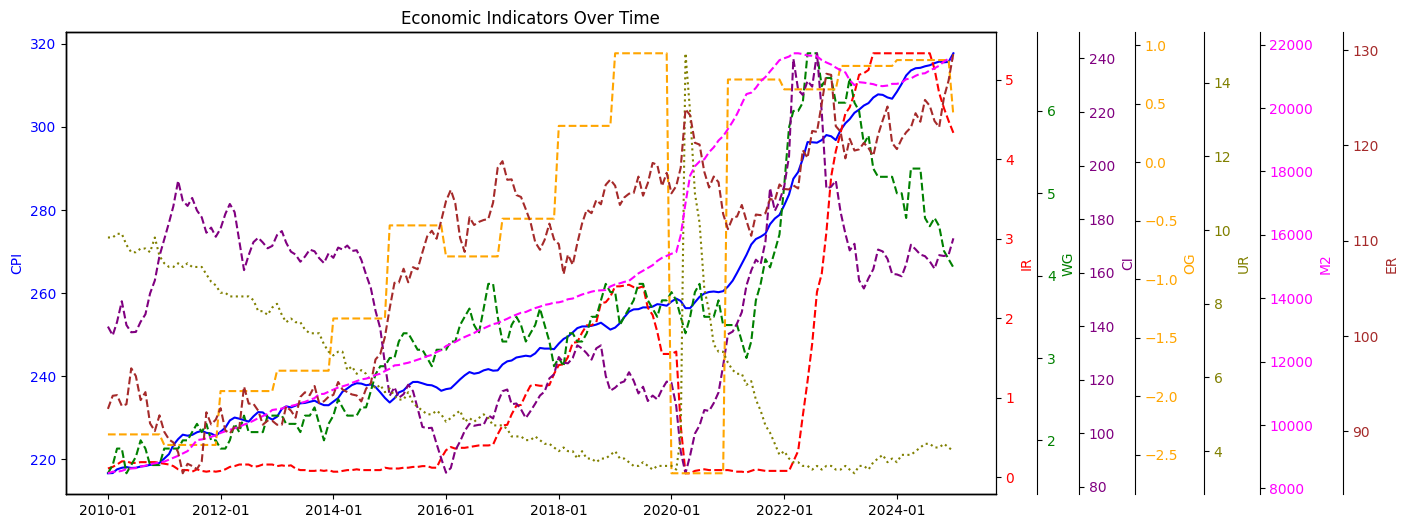

In [3]:

df = pd.read_csv("data/joined.csv")
if "CCI" in df.columns:
    df = df.drop(columns=["CCI"])
latex_table = df.head().to_latex(
    caption="CPI and features are sourced starting from January 2015 till January 2025. "
            "The tables shows the first few entries.",
    index=False,
    float_format="%.6g")
print(latex_table)

# Convert the date column to datetime format
df["date"] = pd.to_datetime(df["date"], format="%b-%y")

# Set the date as the index
df.set_index("date", inplace=True)

# Plot with multiple y-axes
fig, ax1 = plt.subplots(figsize=(12, 6))

# First axis (CPI)
ax1.plot(df.index, df["CPI"], label="CPI", color="blue")
ax1.set_ylabel("CPI", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")

# axis (FEDFUND IR)
ax2 = ax1.twinx()
ax2.plot(df.index, df["IR"], label="IR", color="red", linestyle="dashed")
ax2.set_ylabel("IR", color="red")
ax2.tick_params(axis="y", labelcolor="red")

# axis (Overall wage growth, WG)
ax3 = ax1.twinx()
ax3.spines["right"].set_position(("outward", 30))
ax3.plot(df.index, df["WG"], label="WG", color="green", linestyle="dashed")
ax3.set_ylabel("WG", color="green")
ax3.tick_params(axis="y", labelcolor="green")

# axis (Commodity index, CI)
ax4 = ax1.twinx()
ax4.spines["right"].set_position(("outward", 60))
ax4.plot(df.index, df["CI"], label="CI", color="purple", linestyle="dashed")
ax4.set_ylabel("CI", color="purple")
ax4.tick_params(axis="y", labelcolor="purple")

# axis (Output gap, OG)
ax4 = ax1.twinx()
ax4.spines["right"].set_position(("outward", 100))
ax4.plot(df.index, df["OG"], label="OG", color="orange", linestyle="dashed")
ax4.set_ylabel("OG", color="orange")
ax4.tick_params(axis="y", labelcolor="orange")

# axis (Unemployment rate, UR)
ax4 = ax1.twinx()
ax4.spines["right"].set_position(("outward", 150))
ax4.plot(df.index, df["UR"], label="UR", color="olive", linestyle="dotted")
ax4.set_ylabel("UR", color="olive")
ax4.tick_params(axis="y", labelcolor="olive")

# axis (Money supply, M2)
ax4 = ax1.twinx()
ax4.spines["right"].set_position(("outward", 190))
ax4.plot(df.index, df["M2"], label="M2", color="magenta", linestyle="dashed")
ax4.set_ylabel("M2", color="magenta")
ax4.tick_params(axis="y", labelcolor="magenta")

# axis (Exchange rates, ER)
ax4 = ax1.twinx()
ax4.spines["right"].set_position(("outward", 250))
ax4.plot(df.index, df["ER"], label="ER", color="brown", linestyle="dashed")
ax4.set_ylabel("ER", color="brown")
ax4.tick_params(axis="y", labelcolor="brown")


# Formatting date axis
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.xticks(rotation=45)

plt.title("Economic Indicators Over Time")
plt.savefig("data_raw.pdf", format="pdf", bbox_inches="tight")
plt.show()


### Scale and split

In [216]:
y = df['CPI']
X = df.drop(['CPI'], axis=1)
# scale all features to be between 0 and 1
X = (X - X.min()) / (X.max() - X.min())
# drop data in X and y after 2023 jan
X_fit = X[X.index < "2023-01-01"]  # fit only here
y_fit = y[y.index < "2023-01-01"]
x_pred = X[X.index >= "2023-01-01"] # used for prediction
y_pred = y[y.index >= "2023-01-01"]

## fitting without lasso or ridge

In [219]:
linmodel = LinearRegression(fit_intercept=True)
linmodel.fit(X_fit, y_fit)
mse_values = {}

# Create a DataFrame for coefficients
result = pd.DataFrame(linmodel.coef_.flatten(), index=X_fit.columns, columns=["Lin Reg"])

intercept_value = linmodel.intercept_
r_squared_value = linmodel.score(X_fit, y_fit)

pred = linmodel.predict(X)
pred_mse = linmodel.predict(X_fit)
mse = mean_squared_error(y_fit, pred_mse)

result.loc["in.cpt"] = [intercept_value]
result.loc["$R^2$"] = [r_squared_value]
result.loc["MSE"] = [mse]

# Print LaTeX output
latex_output = result.to_latex(caption="Coefficient values and their names")
print(latex_output)

### Show predicted vs actual

In [220]:
plt.figure(figsize=(10, 6))
plt.plot(y, label='Actual CPI', color='blue')
plt.plot(pd.Series(pred, index=y.index), label='Predicted CPI', color='red')
plt.axvline(pd.to_datetime("2023-01-01"), color='black', linestyle='--', label='Prediction Start')
plt.xlabel('Date')
plt.ylabel('CPI')
plt.title('Actual vs Predicted CPI')
plt.legend()
plt.show()

## Ridge regression

In [ ]:
# do 3 ridge gression with alpha 0.1, 1 and 10
alphas = [0.1, 1, 10]
model = {}
pred = {}
ridge_result = result.copy()
for alpha in alphas:
    model[alpha] = Ridge(alpha=alpha)
    model[alpha].fit(X_fit, y_fit)
    pred[alpha] = model[alpha].predict(X)
    _result = pd.DataFrame(model[alpha].coef_.flatten(), index=X_fit.columns, columns=[f"rid $\\alpha_{{{alpha}}}$"])
    
    intercept_value = model[alpha].intercept_
    r_squared_value = model[alpha].score(X_fit, y_fit)
    pred_MSE = model[alpha].predict(X_fit)
    mse = mean_squared_error(y_fit, pred_MSE)
    _result.loc["MSE"] = [mse]
    _result.loc["in.cpt"] = [intercept_value]
    _result.loc["$R^2$"] = [r_squared_value]

    print("feature coefficients for alpha", alpha, ":", model[alpha].coef_)

    ridge_result = ridge_result.merge(_result, left_index=True, right_index=True)
print(ridge_result.to_latex(caption="Coefficient values and their names for ridge regression"))

# and plot all on 1 graph
plt.figure(figsize=(10, 6))
plt.plot(y, label='Actual CPI', color='black')
colors = ['red', 'orange', 'green']
for alpha, color in zip(alphas, colors):
    plt.plot(pd.Series(pred[alpha], index=y.index), label=f'Predicted CPI (alpha={alpha})', color=color)
plt.plot(pd.Series(linmodel.predict(X), index=y.index), label='Predicted CPI, (alpha=0)', color='blue')
plt.axvline(pd.to_datetime("2023-01-01"), color='black', linestyle='--', label='Prediction Start')
plt.xlabel('Date')
plt.ylabel('CPI')
plt.title('Actual vs Predicted CPI - ridge regression')
plt.legend()
plt.savefig("data_pred_ridge.pdf", format="pdf", bbox_inches="tight")
plt.show()



### lasso regression

In [ ]:
# do 3 lasso gression with alpha 0.1, 1 and 10
alphas = [0.2, 1, 5]
model = {}
pred = {}
lasso_ridge_result = ridge_result.copy()
for alpha in alphas:
    model[alpha] = Lasso(alpha=alpha)
    model[alpha].fit(X_fit, y_fit)
    pred[alpha] = model[alpha].predict(X)
    _result = pd.DataFrame(model[alpha].coef_.flatten(), index=X_fit.columns, columns=[f"las $\\alpha_{{{alpha}}}$"])
    
    intercept_value = model[alpha].intercept_
    r_squared_value = model[alpha].score(X_fit, y_fit)

    pred_MSE = model[alpha].predict(X_fit)
    mse = mean_squared_error(y_fit, pred_MSE)
    _result.loc["MSE"] = [mse]
    _result.loc["in.cpt"] = [intercept_value]
    _result.loc["$R^2$"] = [r_squared_value]

    # print("feature coefficients for alpha", alpha, ":", model[alpha].coef_)

    lasso_ridge_result = lasso_ridge_result.merge(_result, left_index=True, right_index=True)
print(lasso_ridge_result.to_latex(
    caption=("Coefficient values and their names for ridge regression. "
             "in.cpt: axis intercept, lin reg: linear regression, "
             "rid: ridge regression, las: lasso regression"),
    label="tab:ridge_coefficients",
    float_format="%.4g"))

# and plot all on 1 graph
plt.figure(figsize=(10, 6))
plt.plot(y, label='Actual CPI', color='black')
colors = ['red', 'orange', 'green']
for alpha, color in zip(alphas, colors):
    plt.plot(pd.Series(pred[alpha], index=y.index), label=f'Predicted CPI (alpha={alpha})', color=color)
plt.plot(pd.Series(linmodel.predict(X), index=y.index), label='Predicted CPI, (alpha=0)', color='blue')
plt.plot(pd.Series(pred, index=y.index), label='Predicted CPI', color='red')
plt.axvline(pd.to_datetime("2023-01-01"), color='black', linestyle='--', label='Prediction Start')
plt.xlabel('Date')
plt.ylabel('CPI')
plt.title('Actual vs Predicted CPI - lasso regression')
plt.legend()
plt.savefig("data_pred_lasso.pdf", format="pdf", bbox_inches="tight")
plt.show()



## select best model

In [167]:
remove_columns = []
# keep_cols = ["CPI", "IR", "WG", "CI", "OG", "UR", "M2", "ER"]
keep_cols = ["CPI", "WG", "OG", "M2"]
remove_columns = [col for col in df.columns if col not in keep_cols]
# remove_columns = ["date", "CPI", "IR", "WG", "CI", "OG", "UR", "M2", "ER"]
# remove_columns = ["UR", "ER"]
# remove_columns = ["ER", "M2", "UR"]

In [171]:
y = df['CPI']
X = df.drop(['CPI', *remove_columns], axis=1)
# scale all features to be between 0 and 1
X = (X - X.min()) / (X.max() - X.min())
# drop data in X and y after 2023 jan
X_fit = X[X.index < "2023-01-01"]  # fit only here
y_fit = y[y.index < "2023-01-01"]
x_pred = X[X.index >= "2023-01-01"] # used for prediction
y_pred = y[y.index >= "2023-01-01"]
X_fit

In [172]:
linmodel_s = LinearRegression(fit_intercept=True)
linmodel_s.fit(X_fit, y_fit)

# Create a DataFrame for coefficients
result = pd.DataFrame(linmodel_s.coef_.flatten(), index=X_fit.columns, columns=["Lin Reg"])

# Store intercept and R-squared as additional rows
intercept_value = linmodel_s.intercept_
r_squared_value = linmodel_s.score(X_fit, y_fit)

result.loc["Intercept"] = [intercept_value]
result.loc["R-squared"] = [r_squared_value]

# Print LaTeX output
latex_output = result.to_latex(caption="Coefficient values and their names")
print(latex_output)

In [173]:
# do 3 ridge gression with alpha 0.1, 1 and 10
from sklearn.linear_model import Ridge
alphas = [0.1, 1, 10]
model = {}
pred = {}
ridge_result_s = result.copy()
for alpha in alphas:
    model[alpha] = Ridge(alpha=alpha)
    model[alpha].fit(X_fit, y_fit)
    pred[alpha] = model[alpha].predict(X)
    _result = pd.DataFrame(model[alpha].coef_.flatten(), index=X_fit.columns, columns=[f"rid $\\alpha_{{{alpha}}}$"])
    
    intercept_value = model[alpha].intercept_
    r_squared_value = model[alpha].score(X_fit, y_fit)

    _result.loc["Intercept"] = [intercept_value]
    _result.loc["R-squared"] = [r_squared_value]

    print("feature coefficients for alpha", alpha, ":", model[alpha].coef_)

    ridge_result_s = ridge_result_s.merge(_result, left_index=True, right_index=True)
print(ridge_result_s.to_latex(caption="Coefficient values and their names for ridge regression"))

# and plot all on 1 graph
plt.figure(figsize=(10, 6))
plt.plot(y, label='Actual CPI', color='black')
colors = ['red', 'orange', 'green']
for alpha, color in zip(alphas, colors):
    plt.plot(pd.Series(pred[alpha], index=y.index), label=f'Predicted CPI (alpha={alpha})', color=color)
plt.plot(pd.Series(linmodel_s.predict(X), index=y.index), label='Predicted CPI, (alpha=0)', color='blue')
plt.axvline(pd.to_datetime("2023-01-01"), color='black', linestyle='--', label='Prediction Start')
plt.xlabel('Date')
plt.ylabel('CPI')
plt.title('Actual vs Predicted CPI - ridge regression')
plt.legend()
plt.savefig("data_pred_ridge_s.pdf", format="pdf", bbox_inches="tight")
plt.show()



In [174]:
# do 3 lasso gression with alpha 0.1, 1 and 10
from sklearn.linear_model import Lasso
alphas = [0.2, 1, 5]
model = {}
pred = {}
lasso_ridge_result_s = ridge_result_s.copy()
for alpha in alphas:
    model[alpha] = Lasso(alpha=alpha)
    model[alpha].fit(X_fit, y_fit)
    pred[alpha] = model[alpha].predict(X)
    _result = pd.DataFrame(model[alpha].coef_.flatten(), index=X_fit.columns, columns=[f"las $\\alpha_{{{alpha}}}$"])
    
    intercept_value = model[alpha].intercept_
    r_squared_value = model[alpha].score(X_fit, y_fit)

    _result.loc["Intercept"] = [intercept_value]
    _result.loc["R-squared"] = [r_squared_value]

    # print("feature coefficients for alpha", alpha, ":", model[alpha].coef_)

    lasso_ridge_result_s = lasso_ridge_result_s.merge(_result, left_index=True, right_index=True)
print(lasso_ridge_result_s.to_latex(caption="Coefficient values and their names for ridge regression",
    label="tab:ridge_coefficients",
    float_format="%.4g"))

# and plot all on 1 graph
plt.figure(figsize=(10, 6))
plt.plot(y, label='Actual CPI', color='black')
colors = ['red', 'orange', 'green']
for alpha, color in zip(alphas, colors):
    plt.plot(pd.Series(pred[alpha], index=y.index), label=f'Predicted CPI (alpha={alpha})', color=color)
plt.plot(pd.Series(linmodel_s.predict(X), index=y.index), label='Predicted CPI, (alpha=0)', color='blue')
plt.plot(pd.Series(pred, index=y.index), label='Predicted CPI', color='red')
plt.axvline(pd.to_datetime("2023-01-01"), color='black', linestyle='--', label='Prediction Start')
plt.xlabel('Date')
plt.ylabel('CPI')
plt.title('Actual vs Predicted CPI - lasso regression')
plt.legend()
plt.savefig("data_pred_lasso_s.pdf", format="pdf", bbox_inches="tight")
plt.show()



## add CCI

In [197]:
df = pd.read_csv("data/joined.csv")
latex_table = df.head().to_latex(
    caption="CPI and features are sourced starting from January 2015 till January 2025. "
            "The tables shows the first few entries.",
    index=False,
    float_format="%.6g")
print(latex_table)

# Convert the date column to datetime format
df["date"] = pd.to_datetime(df["date"], format="%b-%y")

# Set the date as the index
df.set_index("date", inplace=True)


In [198]:
y = df['CPI']
X = df.drop(['CPI'], axis=1)
# scale all features to be between 0 and 1
X = (X - X.min()) / (X.max() - X.min())
# drop data in X and y after 2023 jan
X_fit = X[X.index < "2023-01-01"]  # fit only here
y_fit = y[y.index < "2023-01-01"]
x_pred = X[X.index >= "2023-01-01"] # used for prediction
y_pred = y[y.index >= "2023-01-01"]

In [207]:
linmodel = LinearRegression(fit_intercept=True)
linmodel.fit(X_fit, y_fit)
mse_values = {}

# Create a DataFrame for coefficients
result = pd.DataFrame(linmodel.coef_.flatten(), index=X_fit.columns, columns=["Lin Reg"])

# Store intercept and R-squared as additional rows
intercept_value = linmodel.intercept_
r_squared_value = linmodel.score(X_fit, y_fit)

pred = linmodel.predict(X)
pred_mse = linmodel.predict(X_fit)
mse = mean_squared_error(y_fit, pred_mse)

result.loc["in.cpt"] = [intercept_value]
result.loc["$R^2$"] = [r_squared_value]
result.loc["MSE"] = [mse]

# Print LaTeX output
latex_output = result.to_latex(caption="Coefficient values and their names")
print(latex_output)

In [208]:
plt.figure(figsize=(10, 6))
plt.plot(y, label='Actual CPI', color='blue')
plt.plot(pd.Series(pred, index=y.index), label='Predicted CPI', color='red')
plt.axvline(pd.to_datetime("2023-01-01"), color='black', linestyle='--', label='Prediction Start')
plt.xlabel('Date')
plt.ylabel('CPI')
plt.title('Actual vs Predicted CPI')
plt.legend()
plt.show()

In [212]:
# do 3 ridge gression with alpha 0.1, 1 and 10
from sklearn.linear_model import Ridge
alphas = [0.1, 1, 10]
model = {}
pred = {}
ridge_result = result.copy()
for alpha in alphas:
    model[alpha] = Ridge(alpha=alpha)
    model[alpha].fit(X_fit, y_fit)
    pred[alpha] = model[alpha].predict(X)
    _result = pd.DataFrame(model[alpha].coef_.flatten(), index=X_fit.columns, columns=[f"rid $\\alpha_{{{alpha}}}$"])
    
    intercept_value = model[alpha].intercept_
    r_squared_value = model[alpha].score(X_fit, y_fit)

    pred_mse = linmodel.predict(X_fit)
    mse = mean_squared_error(y_fit, pred_mse)
    result.loc["MSE"] = [mse]
    _result.loc["in.cpt"] = [intercept_value]
    _result.loc["$R^2$"] = [r_squared_value]

    print("feature coefficients for alpha", alpha, ":", model[alpha].coef_)

    ridge_result = ridge_result.merge(_result, left_index=True, right_index=True)
print(ridge_result.to_latex(caption="Coefficient values and their names for ridge regression"))

# and plot all on 1 graph
plt.figure(figsize=(10, 6))
plt.plot(y, label='Actual CPI', color='black')
colors = ['red', 'orange', 'green']
for alpha, color in zip(alphas, colors):
    plt.plot(pd.Series(pred[alpha], index=y.index), label=f'Predicted CPI (alpha={alpha})', color=color)
plt.plot(pd.Series(linmodel.predict(X), index=y.index), label='Predicted CPI, (alpha=0)', color='blue')
plt.axvline(pd.to_datetime("2023-01-01"), color='black', linestyle='--', label='Prediction Start')
plt.xlabel('Date')
plt.ylabel('CPI')
plt.title('Actual vs Predicted CPI - ridge regression')
plt.legend()
plt.savefig("data_pred_ridge_s.pdf", format="pdf", bbox_inches="tight")
plt.show()



In [215]:
# do 3 lasso gression with alpha 0.1, 1 and 10
from sklearn.linear_model import Lasso
alphas = [0.2, 1, 5]
model = {}
pred = {}
lasso_ridge_result = ridge_result.copy()
for alpha in alphas:
    model[alpha] = Lasso(alpha=alpha)
    model[alpha].fit(X_fit, y_fit)
    pred[alpha] = model[alpha].predict(X)
    _result = pd.DataFrame(model[alpha].coef_.flatten(), index=X_fit.columns, columns=[f"las $\\alpha_{{{alpha}}}$"])
    
    intercept_value = model[alpha].intercept_
    r_squared_value = model[alpha].score(X_fit, y_fit)

    pred_mse = linmodel.predict(X_fit)
    mse = mean_squared_error(y_fit, pred_mse)
    result.loc["MSE"] = [mse]
    _result.loc["in.cpt"] = [intercept_value]
    _result.loc["$R^2$"] = [r_squared_value]

    lasso_ridge_result = lasso_ridge_result.merge(_result, left_index=True, right_index=True)
lasso_ridge_result.drop(index=["IR", "WG", "CI", "OG", "UR", "M2", "ER"], inplace=True)
print(lasso_ridge_result.to_latex(caption="Coefficient values and their names for ridge regression",
    label="tab:ridge_coefficients",
    float_format="%.4g"))

# and plot all on 1 graph
plt.figure(figsize=(10, 6))
plt.plot(y, label='Actual CPI', color='black')
colors = ['red', 'orange', 'green']
for alpha, color in zip(alphas, colors):
    plt.plot(pd.Series(pred[alpha], index=y.index), label=f'Predicted CPI (alpha={alpha})', color=color)
plt.plot(pd.Series(linmodel.predict(X), index=y.index), label='Predicted CPI, (alpha=0)', color='blue')
plt.plot(pd.Series(pred, index=y.index), label='Predicted CPI', color='red')
plt.axvline(pd.to_datetime("2023-01-01"), color='black', linestyle='--', label='Prediction Start')
plt.xlabel('Date')
plt.ylabel('CPI')
plt.title('Actual vs Predicted CPI - lasso regression')
plt.legend()
plt.savefig("data_pred_lasso_s.pdf", format="pdf", bbox_inches="tight")
plt.show()



## fitting till 2018

In [4]:
y = df['CPI']
X = df.drop(['CPI'], axis=1)
# scale all features to be between 0 and 1
X = (X - X.min()) / (X.max() - X.min())
# drop data in X and y after 2023 jan
X_fit = X[X.index < "2018-01-01"]  # fit only here
y_fit = y[y.index < "2018-01-01"]
x_pred = X[X.index >= "2018-01-01"] # used for prediction
y_pred = y[y.index >= "2018-01-01"]

In [5]:
linmodel = LinearRegression(fit_intercept=True)
linmodel.fit(X_fit, y_fit)
mse_values = {}

# Create a DataFrame for coefficients
result = pd.DataFrame(linmodel.coef_.flatten(), index=X_fit.columns, columns=["Lin Reg"])

intercept_value = linmodel.intercept_
r_squared_value = linmodel.score(X_fit, y_fit)

pred = linmodel.predict(X)
pred_mse = linmodel.predict(X_fit)
mse = mean_squared_error(y_fit, pred_mse)

result.loc["in.cpt"] = [intercept_value]
result.loc["$R^2$"] = [r_squared_value]
result.loc["MSE"] = [mse]

# Print LaTeX output
latex_output = result.to_latex(caption="Coefficient values and their names")
print(latex_output)

\begin{table}
\caption{Coefficient values and their names}
\begin{tabular}{lr}
\toprule
 & Lin Reg \\
\midrule
IR & -2.515663 \\
WG & 2.515347 \\
CI & 11.921843 \\
OG & 3.516296 \\
UR & -9.850090 \\
M2 & 65.058352 \\
ER & -3.688137 \\
in.cpt & 218.390430 \\
$R^2$ & 0.989074 \\
MSE & 0.740401 \\
\bottomrule
\end{tabular}
\end{table}



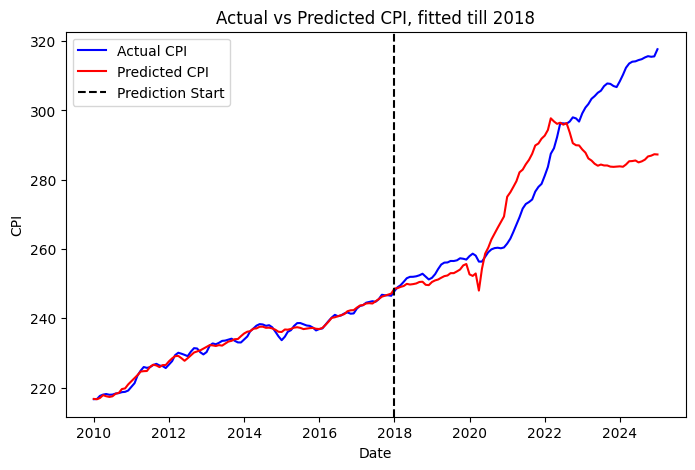

In [9]:
plt.figure(figsize=(8, 5))
plt.plot(y, label='Actual CPI', color='blue')
plt.plot(pd.Series(pred, index=y.index), label='Predicted CPI', color='red')
plt.axvline(pd.to_datetime("2018-01-01"), color='black', linestyle='--', label='Prediction Start')
plt.xlabel('Date')
plt.ylabel('CPI')
plt.title('Actual vs Predicted CPI, fitted till 2018')
plt.legend()
plt.savefig("data_pred_till_2018.pdf")
plt.show()